In [10]:
# Docs
print(__doc__)

Automatically created module for IPython interactive environment


In [11]:
# Imports

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go

## CRISP-DM
![CRISP-DM](../reports/figures/CRISP_DM.png)

#### Load Data

In [12]:
df_analyse= pd.read_csv("../data/processed/COVID_small_sync_timelines.csv", sep=";")

df_analyse= df_analyse.rename(columns={"Unnamed: 0": 'date'})

df_analyse= df_analyse.sort_values("date", ascending=True)

In [3]:
df_analyse.head()

,date,doubling every 10 days,doubling every 12 days,doubling every 15 days,Spain,Nigeria,Germany,Afghanistan,Italy
0,0,1000.000000,1000.000000,1000.000000,1073.0,1095.0,1040.0,1026.0,1128.0
1,1,1071.773463,1059.463094,1047.294123,1695.0,1182.0,1176.0,1092.0,1694.0
2,2,1148.698355,1122.462048,1096.824980,2277.0,1273.0,1457.0,1176.0,2036.0
3,3,1231.144413,1189.207115,1148.698355,2277.0,1337.0,1908.0,1279.0,2502.0
4,4,1319.507911,1259.921050,1203.025036,5232.0,1532.0,2078.0,1351.0,3089.0


#### Helper Functions

In [4]:
# Utility plotting function
def quick_plot(x_data, y_data, type="log", xslider=False):
    """ Basic plot for rapid evaluation of time series data

    Parameters:
    ----------
    x_data: array
        array of numbers or datetime objects
    y_data: pandas dataframe
        matrix to plot, each column is plotted as a trace
        the column name would be used as legend entry for the trace 
    type: str
        y-axis scale, 'log' or 'linear'
    xslider: bool
        x-axis slider, True or False

    Returns:
    -------

    """
    # Create figure
    fig= go.Figure()

    # Column list
    column_list= y_data.columns
    # Loop through each column
    for column in column_list:
        # Add a trace
        fig.add_trace(
            go.Scatter(
                x=x_data,
                y=y_data[column],
                mode="lines",
                opacity=0.8,
                line_width=2,
                marker_size=5,
                name= column
            )
        )

    # Set figure layout
    fig.update_layout(
        width=900,
        height=600,
        xaxis_title="Time",
        xaxis={
            "tickangle": -75,
            "nticks": 20,
            "tickfont": dict(size=14, color="#7f7f7f")
        },
        yaxis_title="Quick Plot",
        yaxis={
            "type": type
        }
    )

    # Introduce range slider on x-axis
    if(xslider):
        fig.update_layout(xaxis_rangeslider_visible=True)

    # Display figure
    fig.show()

In [5]:
# Country list
country_list= df_analyse.columns[1:]

In [6]:
country_list

Index(['doubling every 10 days', 'doubling every 12 days',
       'doubling every 15 days', 'Spain', 'Nigeria', 'Germany', 'Afghanistan',
       'Italy'],
      dtype='object')

In [8]:
# Plot countries
quick_plot(
    df_analyse.date,
    df_analyse.iloc[:, 4:],
    type="linear",
    xslider=True
)

In [22]:
# Extract countries only and cut NaNs
df_poly_fit= df_analyse.iloc[:110, 4:]

df_poly_fit.tail()

,Spain,Nigeria,Germany,Afghanistan,Italy
105,246504.0,45687.0,191272.0,36747.0,236651.0
106,246752.0,46140.0,191768.0,36782.0,236989.0
107,247086.0,46577.0,192480.0,36829.0,237290.0
108,247486.0,46867.0,192871.0,36896.0,237500.0
109,247905.0,47290.0,193371.0,37015.0,237828.0


#### Fitting Models

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [16]:
# Make Polynomial Regression Function

def PolynomialRegression(degree=2, **kwargs):
    """Creates a pipeline model that first generates Polynomial Features of the
        specified degree (Polynomial features for a vector [a,b] for degree 2 is:
        [1, a, b, ab, a^2, b^2]), and then passes that over into a Linear 
        Regression model.
    """

    return make_pipeline(
        PolynomialFeatures(degree),
        LinearRegression(**kwargs)
    )

Create a 1D vector for fitting. The reson of this is because 1D fitting is easier than milti-D fitting. In terms of COVID-19 analysis, I don't see the use of this.

In [23]:
y= df_poly_fit.unstack().sort_index(axis=0, level=1)

In [24]:
y.head()

Spain        0    1073.0
Nigeria      0    1095.0
Germany      0    1040.0
Afghanistan  0    1026.0
Italy        0    1128.0
dtype: float64

**Output**  
Split data into training dataset and testing dataset. Use first 3/4 as training data and last 1/4 as test data.

In [27]:
y_len= len(y)

In [43]:
y_train= y.iloc[:-(y_len//4)]

In [44]:
y_train.tail()

Afghanistan  81     34194.0
Italy        81    227364.0
Spain        82    239228.0
Nigeria      82     34259.0
Germany      82    182922.0
dtype: float64

In [45]:
y_test= y.iloc[-(y_len//4):]

In [46]:
y_test.head()

Afghanistan  82     34366.0
Italy        82    228006.0
Spain        83    239479.0
Nigeria      83     34854.0
Germany      83    183189.0
dtype: float64

**Inputs**  

In [60]:
X_train= np.arange(len(y_train)).reshape(-1,1)/4.0
X_test= np.arange(len(y_test)).reshape(-1,1)/4.0

#### Plotting

In [59]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn;
seaborn.set(rc={'figure.figsize':(16,8)})  # plot formatting, prepare for subplot

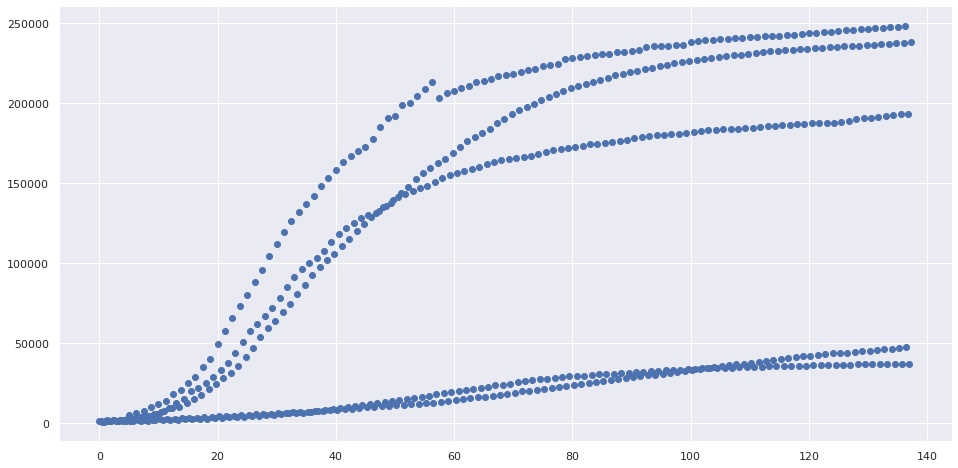

In [64]:
fig, ax1= plt.subplots(1,1)

# Plot ground truth
ax1.scatter(np.arange(y_len)/4, y)

### Alteration

Because it doesn't make sense to lump all the countries in one vector and then 
fit this vector, I have opted to use the data only for Spain.

In [95]:
y= df_analyse.loc[:150, "Spain"]

In [96]:
y.head()

0    1073.0
1    1695.0
2    2277.0
3    2277.0
4    5232.0
Name: Spain, dtype: float64

**Outputs**

In [97]:
y_len=len(y)

y_train= y.iloc[:-(y_len//4)]

y_test= y.iloc[-(y_len//4):]

**Inputs**

In [120]:
X_train= np.arange(len(y_train)).reshape(-1,1)
X_test= np.arange(len(y_train), len(y)).reshape(-1,1)

In [130]:
X_train[-5:]

array([[109],
       [110],
       [111],
       [112],
       [113]])

array([[114],
       [115],
       [116],
       [117],
       [118]])

**Plot**

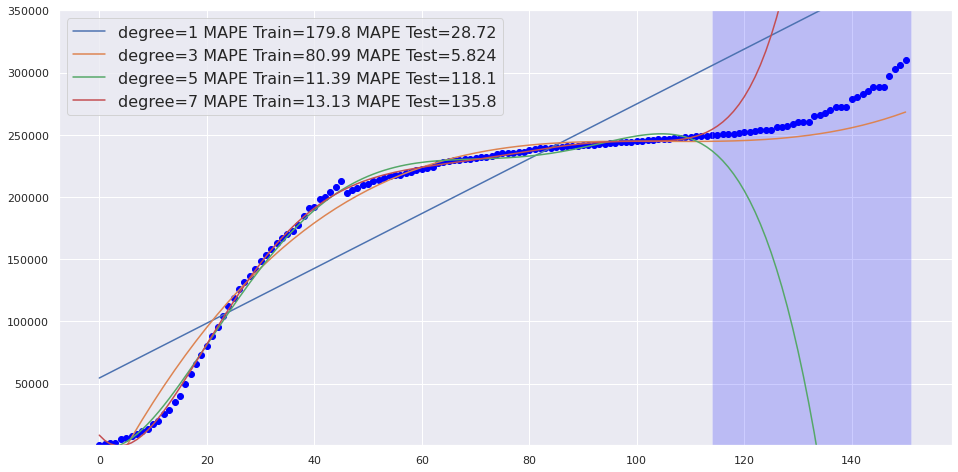

In [149]:
fig, ax1= plt.subplots(1,1)

# Plot ground truth
ax1.scatter(np.arange(y_len), y, color='blue')
# Highlight test range with faded color
ax1.axvspan(len(y_train), len(y), facecolor='blue', alpha=0.2)

# Fit with sprecified degree and plot
degrees=[1, 3, 5, 7]

for degree in degrees:
    fit_model= PolynomialRegression(degree).fit(X_train, y_train)
    y_hat_insample= fit_model.predict(X_train)
    y_hat_test= fit_model.predict(X_test)

    X_plot= np.concatenate((X_train, X_test), axis=None)
    y_plot= np.concatenate((y_hat_insample, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label="degree={} MAPE Train={} MAPE Test={}".format(
        degree,
        str(mean_abs_per_err(y_train, y_hat_insample))[:5],
        str(mean_abs_per_err(y_test, y_hat_test))[:5]
        ))

    #ax1.set_yscale('log')
    #ax1.set_ylim(500, 15000000)
    ax1.set_yscale('linear')
    ax1.set_ylim(500, 350000)

    ax1.legend(loc="best", prop={"size": 16})

## Regression Metrics

#### Mean Absolute Error

Is a measure of error between paired observations expressing the same phnomenon.  
Comparing samples of 'd' (forecast) versus 'y' (actual) across timesteps, we can compute MAE as:

$$ MAE= \frac{ \sum^{n}_{i=1}{ |{y_{i}-d_{i}|} } }{n} $$

#### Mean Absolute Percentage Error

Is a measure of prediction accuracy of a forecasting method.  

$$ MAPE= \frac{1}{n} \sum^{n}_{i=1} \left| \frac{ y_{i}-d_{i} }{y_{i}} \right| $$

In [145]:
def mean_abs_per_err(y_true, y_pred):
    """Compute mean absolute prediction error

        Parameters:
        ----------

        y_true: array

        y_pred: array

        Returns:
        -------
        np.float64
    """
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
